サポートベクトルマシン
==================
学生の「勉強時間（1日あたりの時間）」と「睡眠時間（1日あたりの時間）」を使い、試験に合格したか不合格だったかを分類したいとします。
つまり、2つの説明変数を使って、2つのクラスに分類する問題です。

データをプロットすると{numref}`fig1`のようになりました。
図中の赤四角が合格、青丸が不合格になります。

```{figure} fig1.png
:name: fig1

説明変数とクラスの図
```

分類問題では、クラス間に境目となる直線や曲線を引いて分類を行います。
この境目となる直線や曲線を**決定境界**と呼びます。

```{figure} fig2.png
:name: fig2

決定境界
```

{numref}`fig2`を見てください。
決定境界AとBが引かれており、どちらも分類は正しくされています。
では、どちらの決定境界がより優れているでしょうか？

Aの方が優れていると感じるでしょう。
その理由は、Bの場合、赤枠で囲まれた学生を誤って判定してしまう可能性が高いからです。

```{figure} fig3.png
:name: fig3

マージン
```

誤分類を避けるためには、{numref}`fig3`のように、決定境界から両クラスのデータまでの距離（マージン）が大きい方が望ましいと考えられます。マージンが大きいほど、新しいデータが入ってきたときに、より確実に正しく分類できる可能性が高まります。

「最も近い点（**サポートベクトル**）までの距離が遠くなるよう決定境界を決める」分類手法を、
**サポートベクトルマシン（SVM）**と呼びます。

例えば、2次元において直線の方程式は

```{math}
ax + by + c = 0
```
となります。

このとき、点$(x_i, y_i)$と直線の距離は

```{math}
\frac{|ax_i+by_i+c|}{\sqrt{a^2+b^2}}
```
となるので、全ての学習データ(i=1,2,‥n)に対して

```{math}
min_{i=1,2‥n}\frac{|ax_i+by_i+c|}{\sqrt{a^2+b^2}}
```
を最大化する係数 $a$, $b$ の組み合わせを探します。
これが2次元におけるSVMの学習プロセスとなります。

irisのデータセットを使って分類を考えてみます。
irisの種類には3つありますが、`virginica`を考えず、2種類で考えてみます。

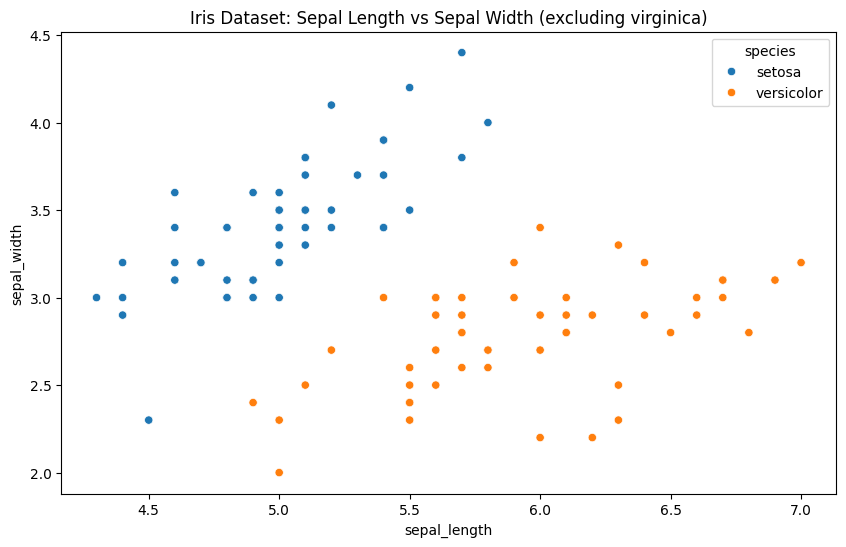

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

iris = sns.load_dataset('iris')
iris_filtered = iris[iris['species'] != 'virginica']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=iris_filtered, x='sepal_length', y='sepal_width', hue='species')
plt.title('Iris Dataset: Sepal Length vs Sepal Width (excluding virginica)')
plt.show()

このデータを`scikit-learn`を使ってSVMで分類してみましょう。
SVMを実行する前は、事前に説明変数を標準化する必要があります。

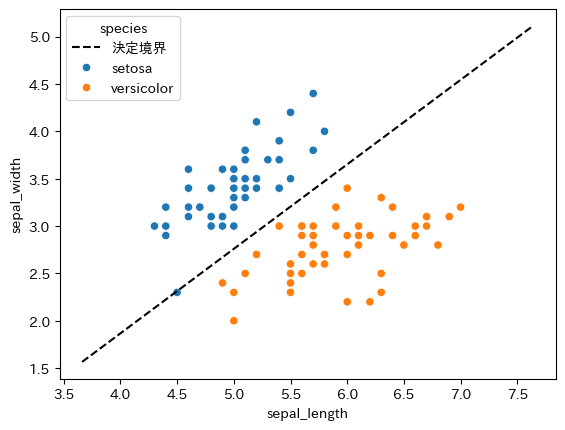

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import japanize_matplotlib

# データの正規化
scaler = StandardScaler()
X = iris_filtered[['sepal_length', 'sepal_width']].values
X_scaled = scaler.fit_transform(X)
y = (iris_filtered['species'] == 'versicolor').astype(int)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_scaled, y)

# 決定境界のパラメータを取得
w = svm_classifier.coef_[0]  # 重み係数 [w1, w2]
b = svm_classifier.intercept_[0]  # バイアス項

# 標準化スケールでのグリッドポイントを生成
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
x_grid = np.linspace(x_min, x_max, 100)

# 決定境界上のポイントを計算（標準化スケール）
# w[0]*x + w[1]*y + b = 0 → y = (-w[0]*x - b) / w[1]
y_grid = (-w[0] * x_grid - b) / w[1]

# 標準化されたグリッドポイントを元のスケールに戻す
grid_points_scaled = np.column_stack((x_grid, y_grid))
grid_points = scaler.inverse_transform(grid_points_scaled)

plt.plot(grid_points[:, 0], grid_points[:, 1], '--k', label='決定境界')
sns.scatterplot(data=iris_filtered, x='sepal_length', y='sepal_width', hue='species')

plt.show()

## カーネルトリック

実際のデータでは、線形の決定境界では適切に分離できない場合が多くあります。
例えば、以下のような場合です。

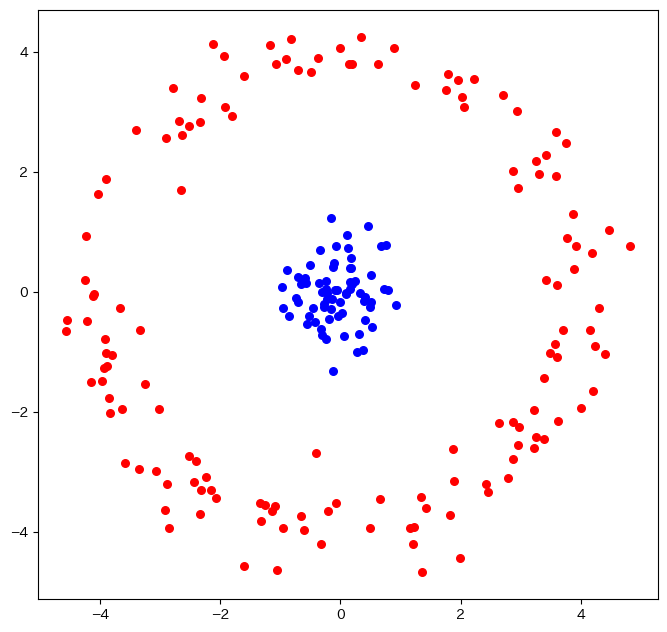

In [3]:
from numpy.random import normal, uniform

np.random.seed(42)
n_points = 70
# 内側の青い点群（正規分布を使用）
blue_points_x = normal(0, 0.5, n_points)
blue_points_y = normal(0, 0.5, n_points)

# 外側の赤い点群（円形に分布）
radius = 4
angles = uniform(0, 2*np.pi, n_points * 2)
radii = normal(radius, 0.4, n_points * 2)
red_points_x = radii * np.cos(angles)
red_points_y = radii * np.sin(angles)

# すべての点の座標を特徴量として結合
X = np.vstack([
    np.column_stack([blue_points_x, blue_points_y]),
    np.column_stack([red_points_x, red_points_y])
])

# クラスラベルを作成（青=0、赤=1）
y = np.concatenate([np.zeros(len(blue_points_x)), np.ones(len(red_points_x))])

plt.figure(figsize=(8, 8))
colors = ['blue', 'red']
for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'Class {i}', s=30)

plt.gca().set_aspect('equal')
plt.show()

このような場合だと、xy座標だけでは、線形の決定境界では分離はできません。

では、このデータに新たにz軸（$z = x^2 + y^2$）を追加してプロットしてみるとどうでしょうか？

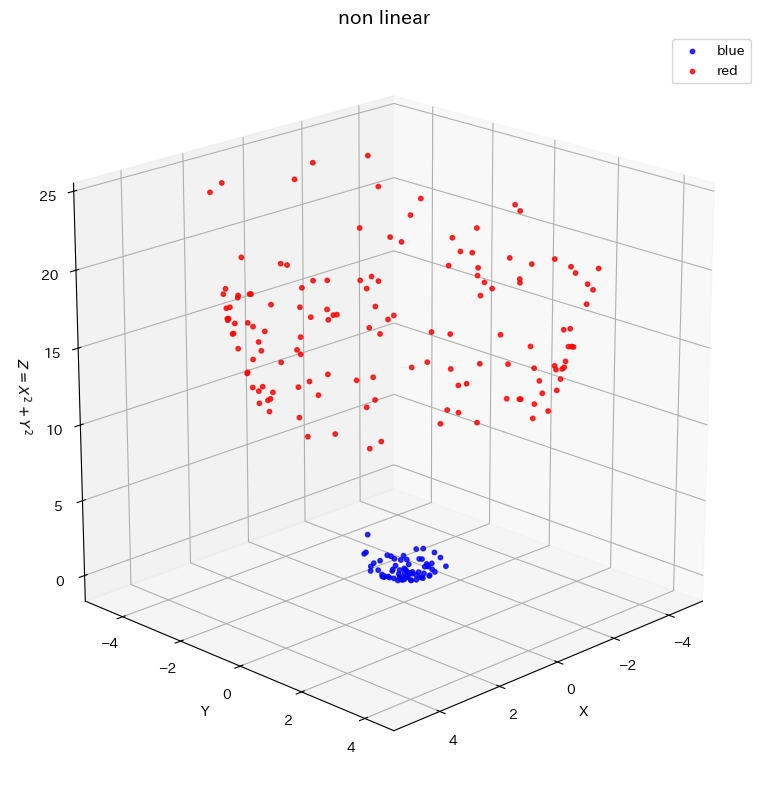

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z = X[:, 0]**2 + X[:, 1]**2

df = pd.DataFrame({
    'x': X[:, 0],
    'y': X[:, 1],
    'z': z,
    'class': ['blue' if c == 0 else 'red' for c in y]
})

# 3Dプロットの設定
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# クラス別にプロット
blue_points = df[df['class'] == 'blue']
red_points = df[df['class'] == 'red']

ax.scatter(blue_points['x'], blue_points['y'], blue_points['z'], c='blue', s=10, alpha=0.8, label='blue')
ax.scatter(red_points['x'], red_points['y'], red_points['z'], c='red', s=10, alpha=0.8, label='red')

ax.set_title('non linear', fontsize=14)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$Z = X^2 + Y^2$')

ax.view_init(elev=20, azim=45)

ax.set_box_aspect([1,1,1])

ax.legend()
plt.tight_layout()
plt.show()

xyzの3軸でみると、ある面(この場合は、$x^2 + y^2 = 4$)で線形の決定境界で分離できそうですね。

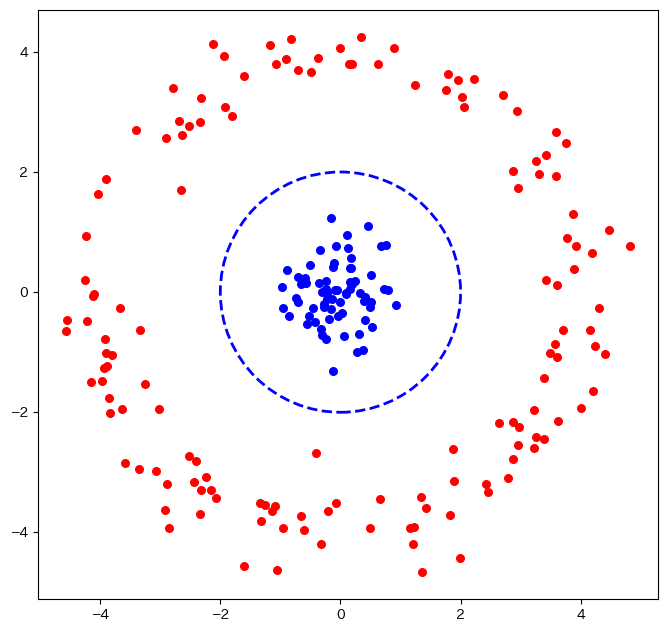

In [5]:
plt.figure(figsize=(8, 8))
colors = ['blue', 'red']
for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'Class {i}', s=30)

circle = plt.Circle((0, 0), 2, fill=False, color='blue', linestyle='--', linewidth=2)
plt.gca().add_patch(circle)

plt.gca().set_aspect('equal')
plt.show()

元のxy座標で考えると、半径2の円が決定境界になります。

線形分離できないデータでも、高次元空間に変換すれば線形分離が可能になります。
この高次元での線形境界を元の空間に戻すと、非線形な決定境界として分類が可能になります。

では、この高次元への変換関数$\phi$はどうやって求めるのでしょうか。
それは

```{math}
K(X_i,X_j)＝\phi(X_i)^T \phi(X_j) 
```
と定義して計算します。
このような変換法を**カーネルトリック**と呼びます。

カーネル関数の中でも特によく使われるのが

```{math}
K(X_i,X_j)＝exp\biggl(-\frac{||X_i-X_j||^2}{2\sigma^2}\biggl)\\
＝exp \Bigl(-\gamma||X_i-X_j||^2 \Bigl)
```
と定義される**RBFカーネル**（Radial Basis Function kernel）です。
この式中に含まれる$\gamma$が、重要な**ハイパーパラメータ**の1つです。

[scikit-learnのドキュメント](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)によると、

- 1つの学習データ点の影響範囲を定義します
- 大きい値: より複雑な決定境界
- 小さい値: よりシンプルな決定境界

という特徴になります。

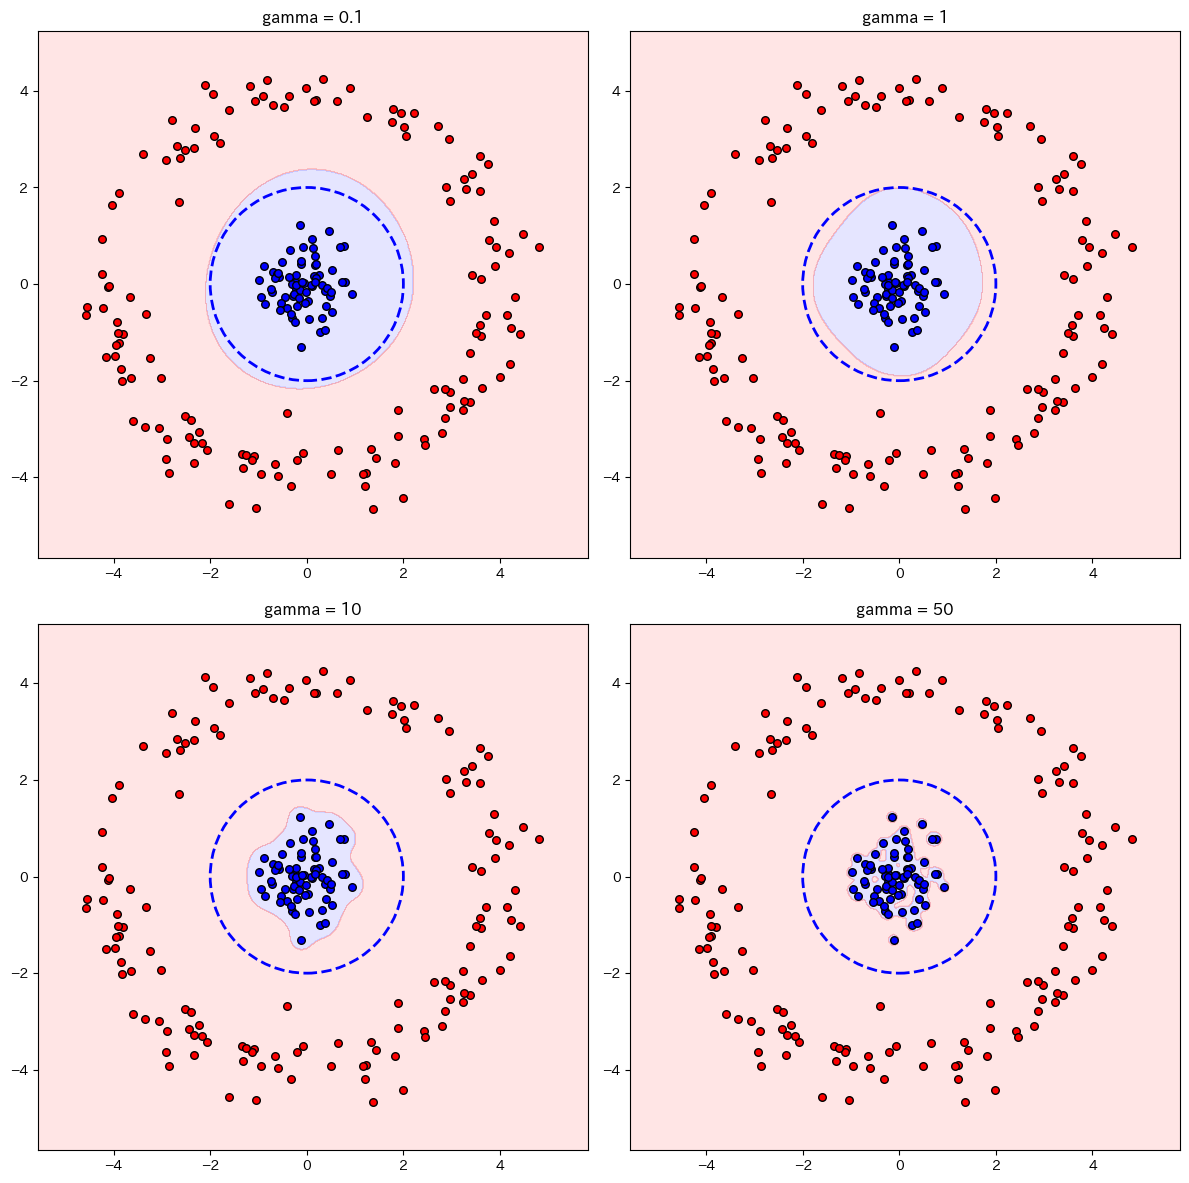

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

# 決定境界を描画する関数
def plot_decision_boundary(X, y, gamma, ax=None):
    # 決定境界用のメッシュを作成
    h = 0.02  # メッシュのステップサイズ
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))
    
    # RBF SVMモデルの構築と学習
    clf = SVC(kernel='rbf', gamma=gamma, C=1.0)
    clf.fit(X, y)
    
    # 決定境界の計算
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 決定境界のプロット
    if ax is None:
        ax = plt.gca()
    
    # カラーマップ定義
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_bold = ['blue', 'red']
    
    # 決定領域を色分けして表示
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    
    # 訓練データをプロット
    for i, color in enumerate(cmap_bold):
        idx = np.where(y == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, label=f'Class {i}', s=30, edgecolor='k')
    
    # 円を描画
    circle = plt.Circle((0, 0), 2, fill=False, color='blue', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    
    ax.set_aspect('equal')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f'gamma = {gamma}')

# 異なるgamma値でのRBF SVMの決定境界を表示
gamma_values = [0.1, 1, 10, 50]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, gamma in enumerate(gamma_values):
    plot_decision_boundary(X, y, gamma, axes[i])

plt.tight_layout()
plt.show()